In [24]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
plt.rcParams["figure.figsize"] = (20,10)
tf.autograph.set_verbosity(0)


In [26]:
from ipynb.fs.defs.UtilitiesVED import *


## Import Data


In [53]:
mpc = 309


In [54]:
test_split =  pd.read_csv("../../Data/data_90TTI/valid_unmask_data_04.csv", index_col=0)
train_split = pd.read_csv("../../Data/data_90TTI/train_data_06.csv", index_col=0)

test_split = test_split.values
train_split = train_split.values

In [55]:
print(test_split.shape)
print(train_split.shape)

(36, 2472)
(54, 2472)


### Subsetting 2 subbands

In [56]:
train_split_sb1_2 = test_split[:,:mpc*4]
test_split_sb1_2 = train_split[:,:mpc*4]

In [57]:
X_train = train_split_sb1_2[:, :mpc*2]
y_train = train_split_sb1_2[:, (mpc*2):]

X_test = test_split_sb1_2[:,mpc*2:]
y_test = test_split_sb1_2[:, (mpc*2):]

In [58]:
print(X_test.shape)
print(y_test.shape)

(54, 618)
(54, 618)


In [59]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_esc = scaler.transform(X_train)
X_test_esc = scaler.transform(X_test)


## Create a sampling layer


## Build the encoder


In [60]:
latent_dim = 100 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
ReLu = keras.layers.ReLU()

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(309, activation=ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001C51EF30CD0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 618)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 309)          191271      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 100)          31000      

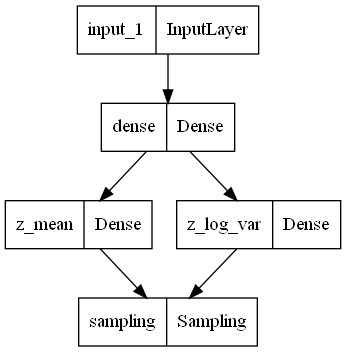

In [61]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [62]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50,  activation=ReLu)(latent_inputs)
decoder_outputs = layers.Dense(618, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 618)               31518     
                                                                 
Total params: 36,568
Trainable params: 36,568
Non-trainable params: 0
_________________________________________________________________


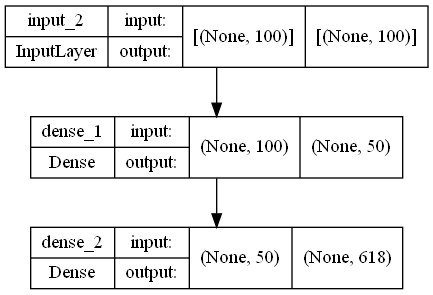

In [63]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


## Train the VAE

In [64]:
vae = VAE(encoder, decoder, 1)

In [65]:
vae.compile(optimizer=keras.optimizers.Adam())

In [66]:
es = keras.callbacks.EarlyStopping(
    monitor="MSE",
    patience=4,
)

In [67]:
history = vae.fit(X_train_esc, y_train, validation_data=(X_test_esc , y_test), epochs=40, batch_size=20)

Epoch 1/40
2/2 [==============================] - 2s 590ms/step - loss: 78.3339 - MSE: 0.2513 - kl_loss: 69.5289 - val_loss_val: 150.0047 - val_MSE_val: 0.3339 - val_kl_loss_val: 150.0903
Epoch 2/40
2/2 [==============================] - 0s 47ms/step - loss: 26.4893 - MSE: 0.1301 - kl_loss: 25.4290 - val_loss_val: 129.5177 - val_MSE_val: 0.2485 - val_kl_loss_val: 129.9948
Epoch 3/40
2/2 [==============================] - 0s 44ms/step - loss: 17.6337 - MSE: 0.1113 - kl_loss: 16.9201 - val_loss_val: 120.1773 - val_MSE_val: 0.2334 - val_kl_loss_val: 120.7658
Epoch 4/40
2/2 [==============================] - 0s 40ms/step - loss: 13.9387 - MSE: 0.1048 - kl_loss: 13.6996 - val_loss_val: 116.8911 - val_MSE_val: 0.2371 - val_kl_loss_val: 117.4907
Epoch 5/40
2/2 [==============================] - 0s 41ms/step - loss: 11.7492 - MSE: 0.0909 - kl_loss: 11.6884 - val_loss_val: 115.9557 - val_MSE_val: 0.2239 - val_kl_loss_val: 116.5431
Epoch 6/40
2/2 [==============================] - 0s 36ms/step -

In [69]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


NRMSE 2.180445280018299
MAE 7.534206963325085
RMSE 1.4381652779936671
MSE 2.1414771314092613


# PLOTS


In [70]:
samp_num = 1

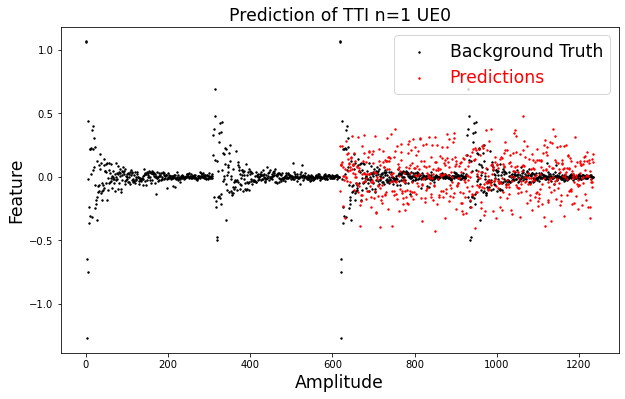

In [71]:
plt_1 = plt.figure(figsize=(10, 6))
sample_1 = np.r_[ y_test[samp_num,], X_test[samp_num,]]
idx = np.arange(len(sample_1))
plt.scatter(np.arange(len(sample_1)), sample_1, s=2, c="black")
plt.scatter(idx[-len(vae.predict(X_test)[samp_num,]):], vae.predict(X_test)[samp_num,], color='red',  s=2)
plt.title('Prediction of TTI n={} UE0'.format(samp_num) , fontsize ='xx-large')
plt.legend(['Background Truth', 'Predictions'],labelcolor = ['black', 'red'] ,loc='upper right', fontsize ='xx-large')
plt.ylabel('Feature', fontsize ='xx-large')
plt.xlabel('Amplitude', fontsize ='xx-large')

plt.show()

In [72]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


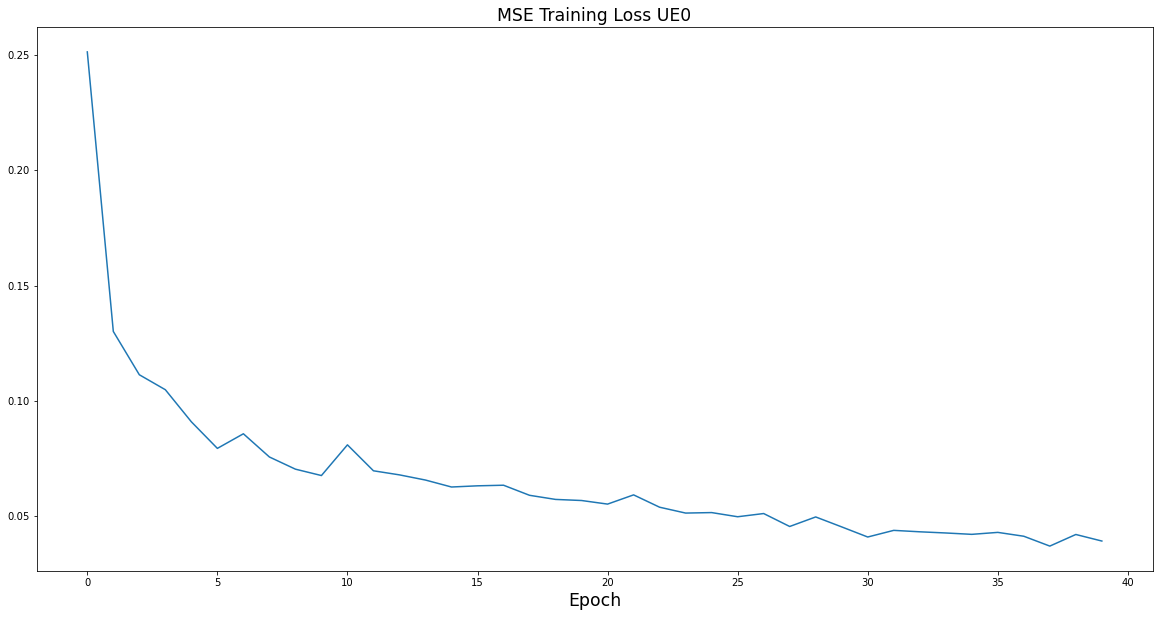

In [73]:
plt.plot(history.history['MSE'])
plt.title('MSE Training Loss UE0', fontsize ='xx-large')
plt.xlabel('Epoch', fontsize ='xx-large')
plt.show()

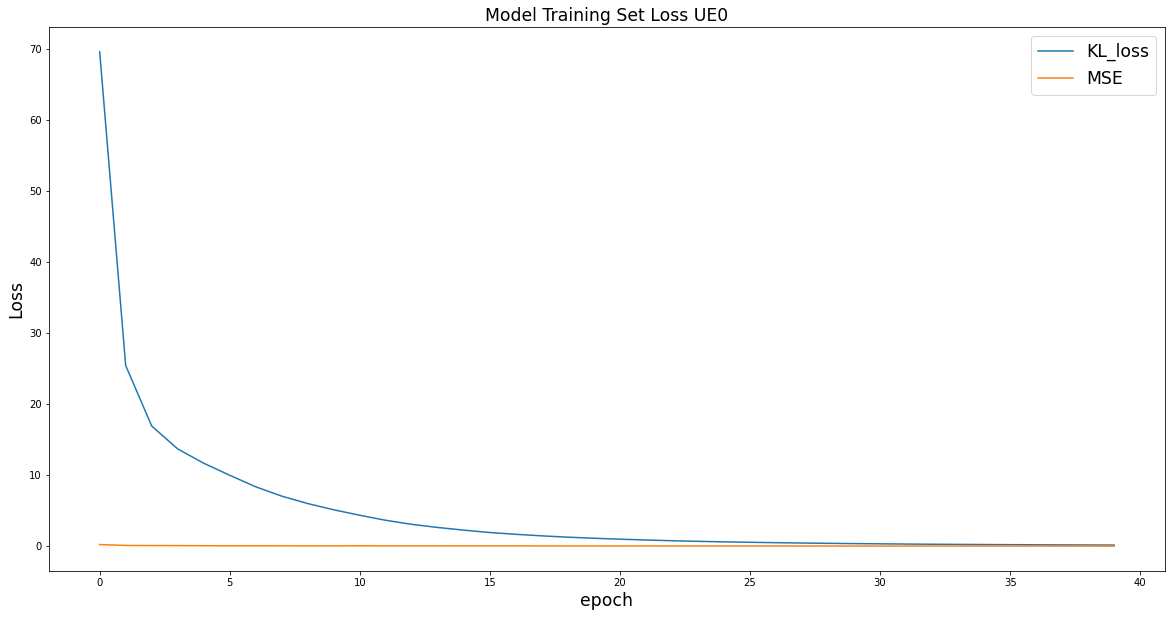

In [74]:
plt.plot(history.history['kl_loss'])
#plt.plot(history.history['val_total_loss'])
plt.title('Model Training Set Loss UE0', fontsize ='xx-large')
plt.ylabel('Loss', fontsize ='xx-large')
plt.xlabel('epoch', fontsize ='xx-large')
plt.plot(history.history['MSE'])
plt.legend(['KL_loss', 'MSE'], loc='upper right', fontsize ='xx-large')
plt.show()


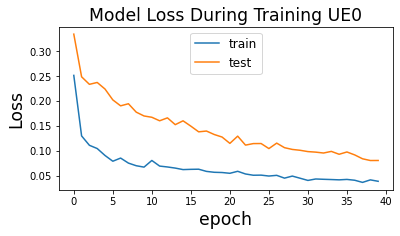

In [75]:
# summarize history for accuracy
plt_1 = plt.figure(figsize=(6, 3))

plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.ylabel('Loss', fontsize ='xx-large')
plt.xlabel('epoch', fontsize ='xx-large')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper center', fontsize ='12')
plt.title('Model Loss During Training UE0', fontsize='xx-large')

plt.show()


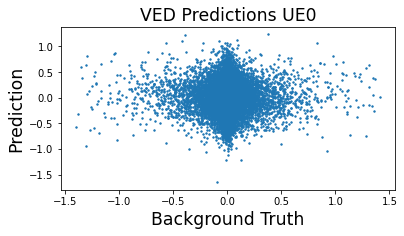

In [76]:
plt_1 = plt.figure(figsize=(6, 3))
plt.scatter(y_test.flatten(), vae.predict(X_test_esc).flatten(), s=2)
plt.title('VED Predictions UE0', fontsize='xx-large')
plt.ylabel('Prediction', fontsize ='xx-large')
plt.xlabel('Background Truth', fontsize ='xx-large')

plt.show()

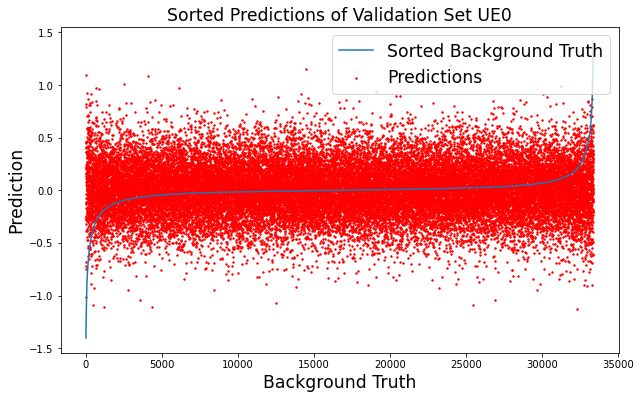

In [77]:
plt_1 = plt.figure(figsize=(10, 6))

plt.plot(np.sort(y_test.flatten()))
x_idx = np.arange(len(y_test.flatten()))
plt.scatter(x_idx, vae.predict(X_test_esc).flatten()[np.argsort(y_test.flatten())], s=2, c="red")

plt.title('Sorted Predictions of Validation Set UE0', fontsize='xx-large')
plt.ylabel('Prediction', fontsize ='xx-large')
plt.xlabel('Background Truth', fontsize ='xx-large')
plt.legend(['Sorted Background Truth', 'Predictions'], loc='upper right', fontsize ='xx-large')

plt.show()


# 

# Modeling

In [78]:
import scipy

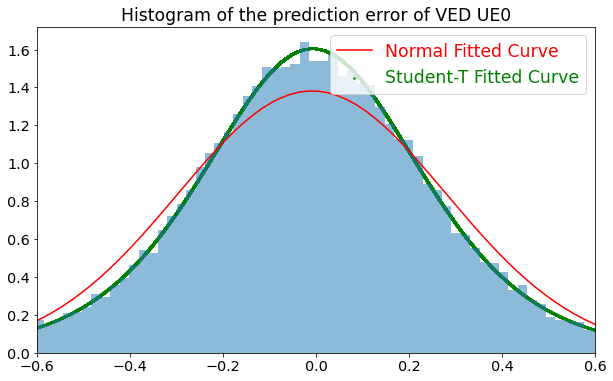

In [79]:
plot_modeling_prediction_error(data, y_test, y_pred, name_ds)

## Plots Over Time

In [82]:
mpc = 309
name_ds = 'DS1B'

In [83]:
plot_MPC_overtime(data, mpc, name_ds, True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

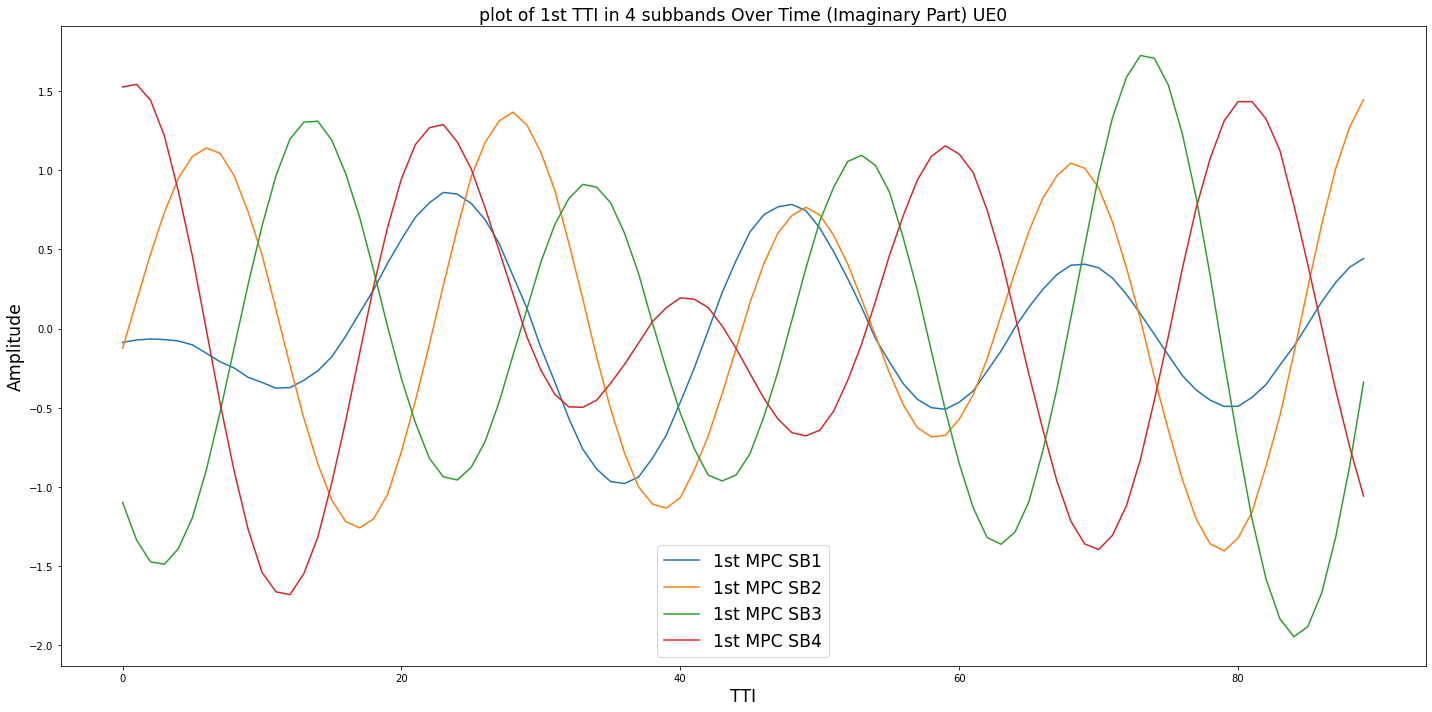

In [34]:
plot_MPC_overtime(data, mpc, name_ds, False)

# Reconstruct the validation set

In [88]:
y_pred = vae.predict(X_test)

y_pred.shape


(54, 618)

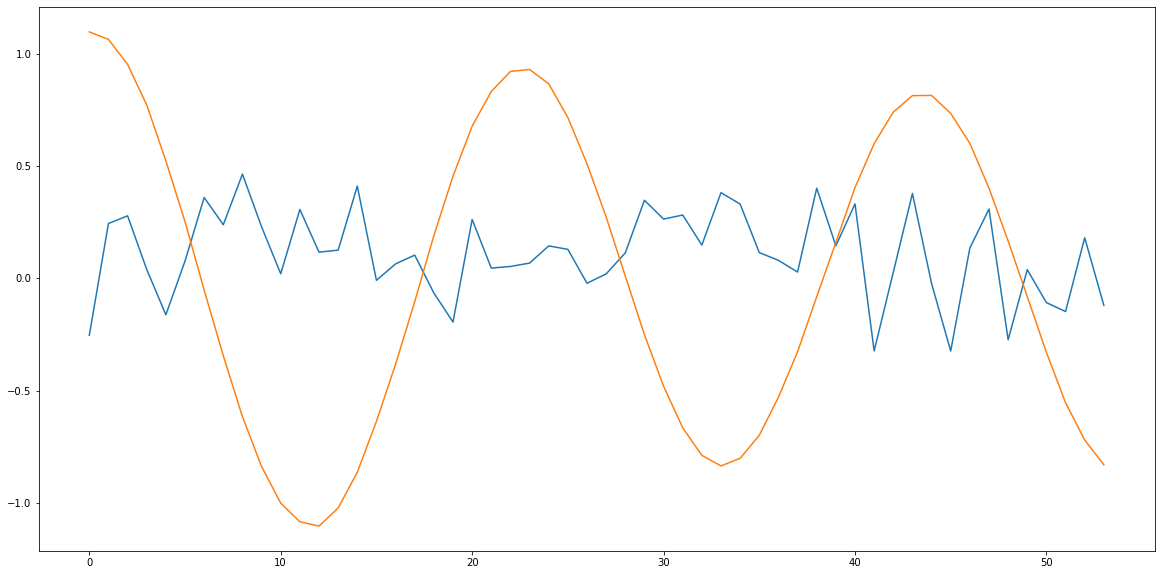

In [98]:
plt.plot(y_pred[:,1])
plt.plot(y_test[:,1])
